# Status de Requições de Materiais

## Dataset

Unimos datasets das Requisições de Materiais no grupo de Materiais, dos Dados Abertos da UFRN, desde 1998

In [145]:
# Importa a biblioteca pandas com o alias 'pd'
import pandas as pd

# Lê um arquivo CSV como delimitador ;
rm = pd.read_csv('data/all_data.csv', delimiter=',')

# Exibe as primeiras linhas do DataFrame 'rm' para visualizar os dados
rm.head()

,numero,ano,requisicao,data,id_unidade_requisitante,unidade_requisitante,id_unidade_custo,unidade_custo,observacoes,grupo_material,convenio,status,tipo_requisicao,almoxarifado,valor
0,2469,1998,2469/1998,29/12/1998,283,EDITORA UNIVERSITÁRIA,283,EDITORA UNIVERSITÁRIA,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 13,80"
1,2468,1998,2468/1998,29/12/1998,1463,RESIDENCIAS UNIVERSITÁRIAS,1463,RESIDENCIAS UNIVERSITÁRIAS,NaN,GAS ENGARRAFADO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 84,00"
2,2470,1998,2470/1998,29/12/1998,253,NÚCLEO PERMANENTE DE CONCURSOS,253,NÚCLEO PERMANENTE DE CONCURSOS,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 4,60"
3,2471,1998,2471/1998,29/12/1998,285,HOSPITAL UNIVERSITARIO ANA BEZERRA,285,HOSPITAL UNIVERSITARIO ANA BEZERRA,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 34,50"
4,2460,1998,2460/1998,28/12/1998,1423,DIRETORIA DE LOGÍSTICA - PROAD,1423,DIRETORIA DE LOGÍSTICA - PROAD,NaN,MATERIAL DE LIMPEZA E PRODUTOS DE HIGIENIZACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 86,56"


## Contexto

Quando uma unidade precisa de algum material, ela abre uma requisição para o almoxarifado. Nessa requisição, deve ter o preço estimado desse material e a unidade que vai custear esse material. Assim, o almoxarifado pode aprová-la e dar início a ordem de compra.

## Ideia

Neste dataset, queremos que, dada uma requisição, prever ele vai ser negada ou autorizada pelo almoxarifado. Além disso, investigar qual perfil das requisições que têm mais chances de serem aprovadas.

## Preprocessamento

Como esse dataset possui registros de devolução e requisições que envolvem serviços, vamos considerar apenas as requisições de material da instituição

In [146]:
df = rm[rm['tipo_requisicao'] == 'REQUISIÇÃO DE MATERIAL']

Algumas colunas em nada agregam ao nosso objetivo, portanto vamos retirá-las

In [147]:
df = df.drop(['numero','ano','requisicao','data','observacoes','grupo_material','tipo_requisicao','unidade_custo','id_unidade_custo','id_unidade_requisitante'], axis=1)

A coluna status é multivalorada, mas apenas nos importa saber se a requisição foi negada ou não.

In [148]:
# Filtrar apenas requisições negadas, autorizadas e que tiveram a compra efetuada
df = df[df['status'].isin(['NEGADA', 'AUTORIZADA', 'COMPRA', 'LIQUIDADA', 'EM_LIQUIDACAO'])]

# Substituir 'NEGADA' por 1 e outros valores por 0 na coluna 'status'
df['status'] = df['status'].apply(lambda x: 1 if x == 'NEGADA' else 0)

Vamos categorizar as unidades requisitantes de interesse

In [149]:
# Unidades requisitantes de interesse
request_unit = ['ADMINISTRAÇÃO', 'SECRETARIA', 'DEPARTAMENTO', 'COORDENAÇÃO', 'ALMOXARIFADO', 'ASSESSORIA', 'ASSISTÊNCIA', 'BIBLIOTECA', 'PRÓ-REITORIA', 'HUOL']

# Função para realizar a substituição
def categorize_request_unit(value):
    for idx, rq in enumerate(request_unit):
        if value.startswith(rq):
            return idx
    return len(request_unit)

# Aplicar a função à coluna "unidade_requisitante" e criar uma nova coluna com os valores substituídos
df['unidade_requisitante'] = df['unidade_requisitante'].apply(categorize_request_unit)

As colunas convenio e almoxarifado são interessantes, mas são categóricas. Portanto, precisão ser tratadas. Abaixo uma função que facilita esse trabalho

In [150]:
from sklearn.preprocessing import LabelEncoder

def categorize(dataframe, column):
    """
    Recebe um dataframe e a coluna com os dados categóricos que se quer rotular

    Args:
        dataframe (object DataFrame)
        column (string)
    """
    # Identificar categorias de column
    data = {category for category in set(dataframe[column])} 
    
    # Traduzir cada categoria para numeros
    label_encoder = LabelEncoder()
    
    # Atualiza no dataframe
    dataframe[column] = label_encoder.fit_transform(dataframe[column])
    
    # Obtenha as categorias originais e seus rótulos numéricos
    categories = label_encoder.classes_
    labels = label_encoder.transform(categories)

    # Visualizar mapeamento
    display(pd.DataFrame({'Categoria':categories, 'Rótulo Numérico': labels}))

In [151]:
categorize(df, 'convenio')

,Categoria,Rótulo Numérico
0,False,0
1,True,1


In [152]:
categorize(df, 'almoxarifado')

,Categoria,Rótulo Numérico
0,ALMOXARIFADO - CB,0
1,ALMOXARIFADO - CCET,1
2,ALMOXARIFADO - CCHLA,2
3,ALMOXARIFADO - CCHLA - PORTARIA 097/2014,3
4,ALMOXARIFADO - CCS,4
5,ALMOXARIFADO - CCSA,5
6,ALMOXARIFADO - CT,6
7,ALMOXARIFADO CENTRAL,7
8,ALMOXARIFADO DE MATERIAIS DE MANUTENÇÃO DE IMÓ...,8
9,ALMOXARIFADO HUAB,9


A coluna `valor` precisa ser transformada em valores decimais

In [153]:
import re

rgx_remove_prefix = r'R\$|\s'
rgx_only_last_point = r'\.(?=[^.]*\.)'

df.loc[:,'valor'] = df['valor'].apply(lambda value: re.sub(rgx_only_last_point, '', re.sub(rgx_remove_prefix, '', value).replace(',', '.')))
df.loc[:,'valor'] = df['valor'].astype(float)

Verificar linhas que possuem valores NaN

In [154]:
df.isna().sum()

unidade_requisitante    0
convenio                0
status                  0
almoxarifado            0
valor                   0
dtype: int64

O proximo passo é categorizar as colunas dos valores baseando-se pelo box plot apresentado abaixo

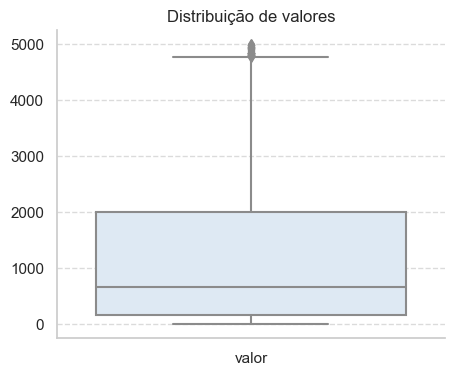

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar os valores que estão dentro de um intervalo mais apropriado
df_copy = df[df['valor'] < 5000]

# Definir uma paleta de cores personalizada (opcional)
custom_palette = sns.color_palette("Blues")

# Criar um boxplot com Seaborn
plt.figure(figsize=(5, 4)) 
sns.set(style="whitegrid")

ax = sns.boxplot(data=df_copy[['valor']], palette=custom_palette)
ax.set_title('Distribuição de valores')

# Adicione um grid de fundo mais claro
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remova a moldura superior e direita
sns.despine()

# Mostre o boxplot
plt.show()

In [156]:
def categorize_value(value):
    if value < 1000:
        return 0
    elif value >= 1000 and value <= 2000:
        return 1
    elif value > 2000 and value < 4000:
        return 2
    elif value >= 4000 and value < 5000:
        return 3
    return 4

df.loc[:,'valor'] = df['valor'].apply(categorize_value)

Abaixo é possível ver quantas requisições foram negadas (status 0) e quantas foram aprovadas (status 1)

In [157]:
df['status'].value_counts()

status
0    3374
1     801
Name: count, dtype: int64

In [158]:
df

,unidade_requisitante,convenio,status,almoxarifado,valor
39292,7,0,0,13,4
39841,10,0,0,13,4
39842,10,0,0,13,1
40717,2,0,0,13,1
40802,2,0,0,13,1
...,...,...,...,...,...
620056,0,0,1,7,1
621466,10,0,1,8,2
621869,4,0,1,7,0
622018,0,0,1,7,0


## Avaliação de classificador

In [159]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Classe para avaliar as técnicas supervisionadas
class AssessClassifier:
    """
    Inicialização da avaliação do classificador

    Parâmetros:
        df    (DataFrame)      : dataframe onde se encontram os dados
        clf   (sklearn object) : classificador
        label (string)         : nome da coluna do rótulo no dataframe
    """
    def __init__(self, df, clf, label):
        # Armazena o dataframe e o classificador nas propriedades
        self.df = df
        self.clf = clf
        
        # Separando X (features) e y (label)
        X = df.drop(label, axis=1)
        y = df.status

        # Divisao treino e test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.20, random_state=0)

    """
    Treinamento do classificador
    """
    def train(self):
        # Treinar classificador
        self.clf = self.clf.fit(self.X_train, self.y_train)
        # Verificar score com dados de treino
        print('Score do treinamento: ', self.clf.score(self.X_train, self.y_train))

    """
    Teste do classificador
    """
    def test(self):
        # Faça a predição
        self.y_pred = self.clf.predict(self.X_test)

    """
    Plotar matriz de confusão
    """
    def get_cm(self):
        return confusion_matrix(self.y_test,self.y_pred)

    """
    Plotar curva ROC
    """
    def get_roc(self):
        y_prob = self.clf.predict_proba(self.X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(self.y_test, y_prob)
        return fpr, tpr

    """
    Mostrar acurácia, precisão e sensibilidade do modelo
    """
    def get_metrics(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        return accuracy, precision, recall

    """
    Refinar hiperparâmetros pela otimização pseudo aleatória
    """
    def refine_rs(self, search_space):
        rs = RandomizedSearchCV(
            self.clf, 
            search_space, 
            n_iter=10, 
            scoring='accuracy', 
            verbose=True, cv=5,
            n_jobs=-1, 
            return_train_score=True)
        rs.fit(self.X_train, self.y_train)
        
        return rs.best_estimator_

    """
    Refinar hiperparâmetros pela otimização por grid search
    """
    def refine_gs(self, search_space):
        gs = GridSearchCV(
          self.clf,
          search_space,
          cv=5,
          scoring='accuracy',
          return_train_score=True)
        gs.fit(rf.X_train, rf.y_train)
        
        return gs.best_estimator_
        
    """
    Refinar hiperparametros pela busca bayesiana
    """
    def refine_bs(self, search_space):
        bs = BayesSearchCV(
            self.clf,
            search_space, 
            n_iter = 10, 
            scoring = 'accuracy', 
            n_jobs = 1, cv = 5)
        bs.fit(self.X_train, self.y_train)
        
        return bs.best_estimator_

## Técnicas supervisionadas

### Gradient Boosting Tree

In [160]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb_clf = HistGradientBoostingClassifier()

gb = AssessClassifier(df, gb_clf, 'status')
gb.train()
gb.test()

Score do treinamento:  0.9640718562874252


### Floresta Aleatória

In [161]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier() 

rf = AssessClassifier(df, rf_clf, 'status')
rf.train()
rf.test()

Score do treinamento:  0.9652694610778443


### Refino dos hiperparâmetros

In [162]:
rf_search_space = {
    'bootstrap': [True],              # Se amostras são retiradas com reposição
    'max_depth': [10, 25, 30],        # Profundidade máxima da árvore
    'max_features': [2, 3],           # Número máximo de features consideradas para divisão
    'min_samples_leaf': [3, 5],       # Número mínimo de amostras necessárias para estar em um nó folha
    'min_samples_split': [8, 10, 12], # Número mínimo de amostras necessárias para dividir um nó interno
    'n_estimators': [100, 350]        # Número de árvores na floresta
}

gb_search_space = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],     # Taxa de aprendizado
    'max_iter': [100, 200, 300],                # Número máximo de iterações
    'max_depth': [3, 4, 5, 6],                  # Profundidade máxima da árvore
    'min_samples_leaf': [1, 2, 3, 4],           # Número mínimo de amostras em uma folha
    'l2_regularization': [0.0, 0.1, 0.2, 0.3],  # Regularização L2
    'max_bins': [155, 205, 255]                 # Número máximo de bins para histograma
}

#### Random Search

Realiza a busca em um subconjunto aleatório de combinações, tornando-a uma alternativa mais eficiente quando temos muitos parâmetros para sintonizar. Essa abordagem é útil quando a precisão do modelo é uma prioridade e o tempo de treinamento precisa ser controlado, uma vez que não explora todas as opções, mas busca resultados significativos em uma fração do tempo.

In [163]:
gb_rs = gb.refine_bs(gb_search_space)
# rf_rs = rf.refine_bs(rf_search_space)

In [164]:
gb_rs

HistGradientBoostingClassifier(max_bins=205, max_depth=6, min_samples_leaf=2)

### Atualização dos classificadores

In [165]:
gb = AssessClassifier(df, gb_rs, 'status')
gb.train()
gb.test()

Score do treinamento:  0.9652694610778443


In [166]:
# rf = AssessClassifier(df, rf_rs,'status')
# rf.train()
# rf.test()

### Comparações

#### Métricas de acurácia, sensibilidade e precisão

In [167]:
rf_accuracy, rf_precision, rf_recall = rf.get_metrics()
gb_accuracy, gb_precision, gb_recall = gb.get_metrics()

metrics = dict()
metrics['classifier'] = ['HistGradientBoostingClassifier', 'RandomForestClassifier']
metrics['accuracy'] = [gb_accuracy, rf_accuracy]
metrics['precision'] = [gb_precision, rf_precision]
metrics['recall'] = [gb_recall, rf_recall]

pd.DataFrame(metrics)

,classifier,accuracy,precision,recall
0,HistGradientBoostingClassifier,0.960479,0.891156,0.885135
1,RandomForestClassifier,0.961677,0.891892,0.891892


#### Matriz de confusão

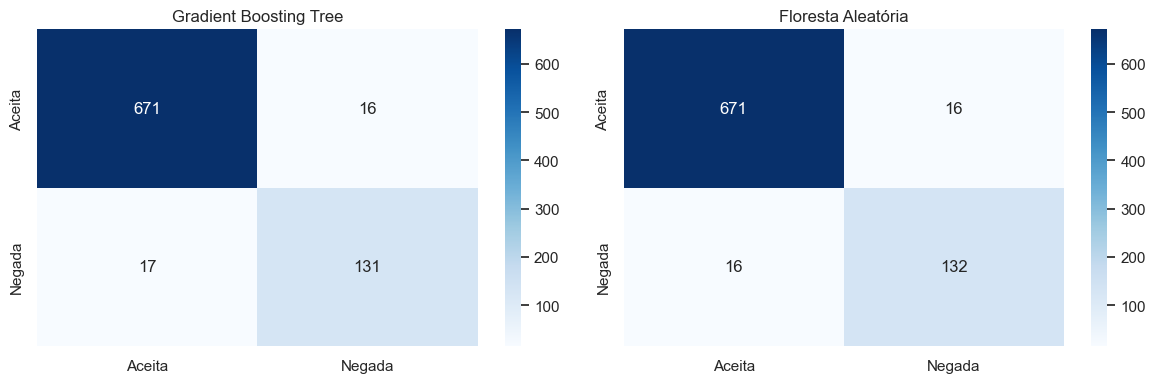

In [168]:
gb_cm = gb.get_cm()
rf_cm = rf.get_cm()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(gb_cm, annot=True, fmt="d", ax=axes[0], cmap="Blues", xticklabels=["Aceita", "Negada"], yticklabels=["Aceita", "Negada"])
axes[0].set_title("Gradient Boosting Tree")

sns.heatmap(rf_cm, annot=True, fmt="d", ax=axes[1], cmap="Blues", xticklabels=["Aceita", "Negada"], yticklabels=["Aceita", "Negada"])
axes[1].set_title("Floresta Aleatória")

plt.tight_layout()
plt.show()

#### Curva ROC

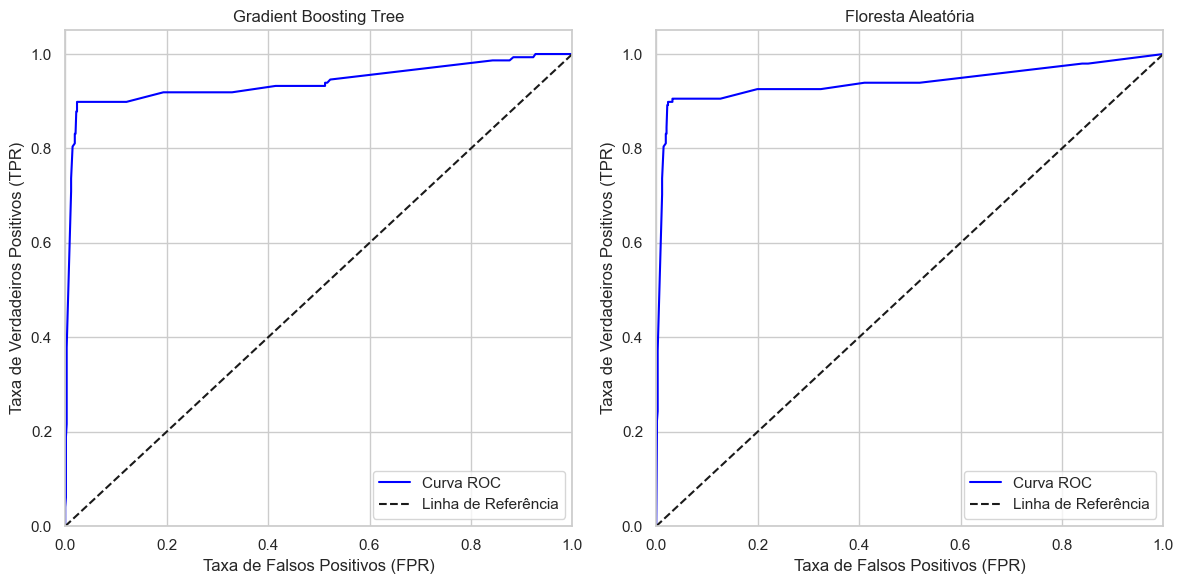

In [169]:
plt.figure(figsize=(12, 6))

def plot_roc(title, object):
    fpr, tpr = object.get_roc()
    plt.plot(fpr, tpr, label='Curva ROC', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Linha de Referência')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(title)
    plt.legend(loc='lower right')

plt.subplot(1, 2, 1)
plot_roc('Gradient Boosting Tree', gb)

plt.subplot(1, 2, 2) 
plot_roc('Floresta Aleatória', rf)

plt.tight_layout()

plt.show()            

## Técnica não supervisionada

Utilizou-se o SOM para identificar o agrupamento de requisições que foram aprovadas e que foram negadas

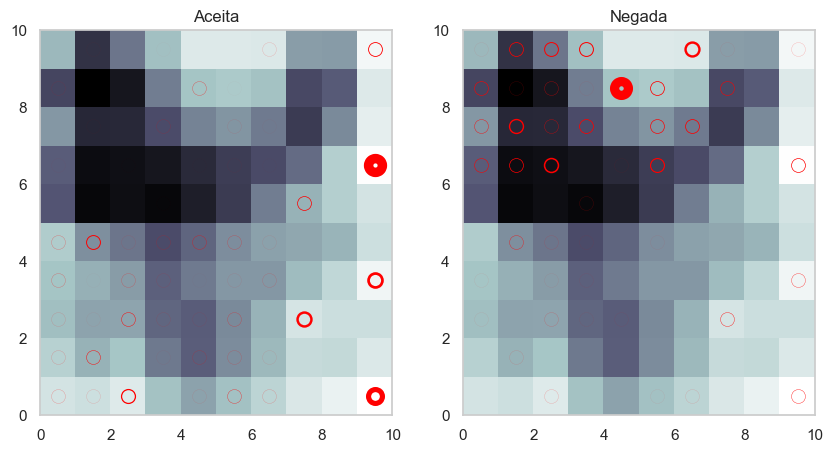

In [170]:
from minisom import MiniSom

# Extrair as features
x = df.drop(columns = ['status','convenio'])
data = np.array(x, dtype=np.float64)

# Inicialize a rede SOM.
som = MiniSom(10, 10, data.shape[1], sigma=1.5, learning_rate=0.5, neighborhood_function='gaussian', random_seed=0)

# Inicialize os pesos da PCA.
som.pca_weights_init(data)

# Treine a rede SOM.
som.train(data, 10000)

# Crie a figura com dois subplots.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Calcular intensidade de cada neurônio vencedor
def calc_intensity(w):
    coords, counts = np.unique(w, return_counts=True, axis=0)
    coord_x = coords[:, 0]
    coord_y = coords[:, 1]
    intensity = counts / counts.sum()
    return coord_x, coord_y, intensity

for idx, label in enumerate(df['status'].drop_duplicates()):
    # Plote o mapa de distância.
    axs[idx].set_title('Aceita' if label == 0 else 'Negada')
    axs[idx].pcolor(som.distance_map().T, cmap='bone_r')
    
    # Encontre os vencedores (neurônios vencedores) para os dados com a classe label
    w = [som.winner(d) for d in data[df['status'] == label]]

    # Calcule as coordenadas e intensidade dos neurônios vencedores.
    x_points, y_points, intensity = calc_intensity(w)
    
    # Faça o gráfico dos pontos no primeiro subplot.
    for i in range(len(intensity)):
        axs[idx].plot(x_points[i] + 0.5, y_points[i] + 0.5, "o", markerfacecolor='None', markeredgecolor="red", markersize=10, markeredgewidth=20 * intensity[i])
        
# Exiba a figura.
plt.show()

### Erro topográfico

O erro topológico avalia a capacidade do SOM de preservar a topologia e a organização espacial dos dados de entrada no mapa de neurônios. Baixos valores de erro topológico indicam que a estrutura relativa dos dados é bem preservada no SOM.

In [171]:
som.topographic_error(data)

0.0081437125748503

### Erro de quantização

O erro de quantização mede o quão bem os neurônios no SOM representam os dados de entrada. Valores baixos indicam uma representação de alta qualidade, onde os neurônios correspondem de forma precisa aos padrões nos dados de entrada.

In [172]:
som.quantization_error(data)

0.10020273774986817